In [1]:
import copy, cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from models import regressionnet
from scripts import tools
from scripts import dataset
from scripts.config import *

%matplotlib inline

tools.etc.set_GPU("3")

In [2]:
net, _, _, _ = regressionnet.create_regression_net(data_shape=(227,227,3),optimizer_type='adadelta',num_joints=14)
    
with net.graph.as_default():
    saver = tf.train.Saver()
    saver.restore(net.sess, "./out/alexnet_gpu1_9900.ckpt")
    test_it = dataset.met("./dataset/test.csv", Fliplr=True, dataset_root="./dataset/")

INFO:tensorflow:Restoring parameters from ./out/alexnet_gpu1_9900.ckpt


[Mirroring Images & Coordinates]: 100%|██████████| 60/60 [00:00<00:00, 1404.37it/s]


In [3]:
predicted_joints = net.sess.run(
    [net.fc_regression],
    feed_dict={net.x : test_it.img_set, net.keep_prob:1.0})[0]

predicted_joints = predicted_joints.reshape(len(predicted_joints),14,2)
pred_canonical = tools.pose.convert2canonical(predicted_joints)
orig_canonical = tools.pose.convert2canonical(test_it.coor_set)

In [4]:
pcp_value=tools.pose.eval_strict_pcp(orig_canonical,pred_canonical)
average_pcp = tools.pose.average_pcp_left_right_limbs(pcp_value)
for i in range(len(average_pcp[1])):
    print(average_pcp[1][i]+" : "+str(average_pcp[0][i]))

Head : 0.375
Torso : 0.7083333333333334
U Arm : 0.475
L Arm : 0.3041666666666667
U Leg : 0.5
L Leg : 0.5375
mean : 0.4833333333333334


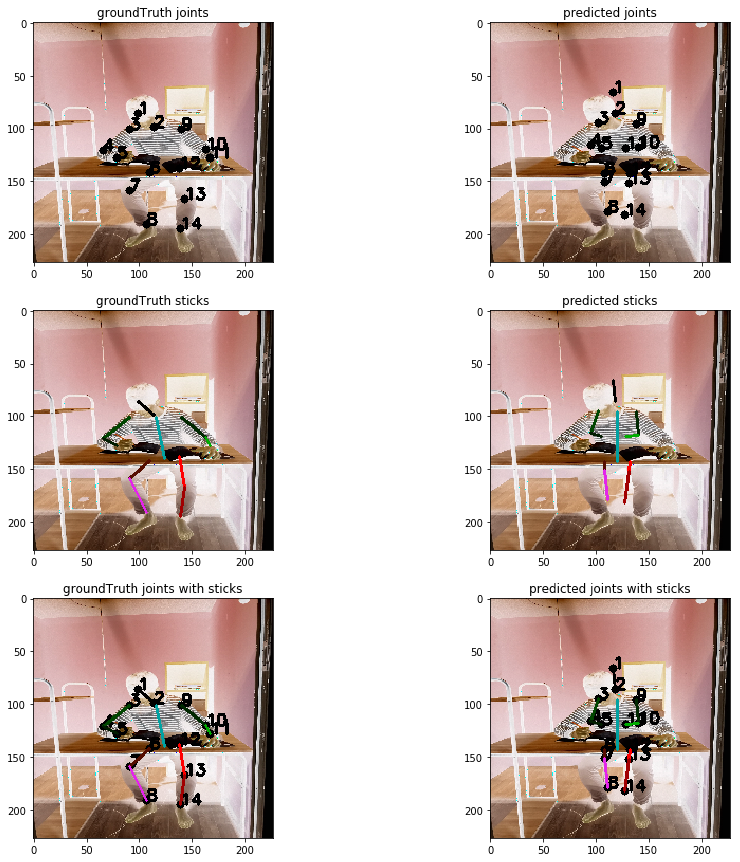

In [5]:
idx=28

orig_img1 = test_it.img_set[idx].copy()
orig_img2 = test_it.img_set[idx].copy()
orig_img3 = test_it.img_set[idx].copy()

pred_img1 = test_it.img_set[idx].copy()
pred_img2 = test_it.img_set[idx].copy()
pred_img3 = test_it.img_set[idx].copy()

tools.etc.markJoints(img=orig_img1, joints=orig_canonical[idx]['joints'])
tools.etc.drawSticks(img=orig_img2, sticks=orig_canonical[idx]['sticks'])

tools.etc.markJoints(img=pred_img1, joints=pred_canonical[idx]['joints'])
tools.etc.drawSticks(img=pred_img2, sticks=pred_canonical[idx]['sticks'])

tools.etc.markJoints(img=orig_img3, joints=orig_canonical[idx]['joints'])  
tools.etc.drawSticks(img=orig_img3, sticks=orig_canonical[idx]['sticks'])  

tools.etc.markJoints(img=pred_img3, joints=pred_canonical[idx]['joints'])
tools.etc.drawSticks(img=pred_img3, sticks=pred_canonical[idx]['sticks'])

fig, ((p11,p12),(p21,p22),(p31,p32),) = plt.subplots(3,2)
fig.set_size_inches(15, 15)

p11.set_title("groundTruth joints")
p11.imshow(orig_img1)
p12.set_title("predicted joints")
p12.imshow(pred_img1)

p21.set_title("groundTruth sticks")
p21.imshow(orig_img2)
p22.set_title("predicted sticks")
p22.imshow(pred_img2)

p31.set_title("groundTruth joints with sticks")
p31.imshow(orig_img3)
p32.set_title("predicted joints with sticks")
p32.imshow(pred_img3)